<a href="https://colab.research.google.com/github/mark-polo/100DaysOfTriton/blob/main/100DaysOfTriton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install triton

In [2]:
import torch

import triton
import triton.language as tl

# Day 1

In [ ]:
@triton.jit
def _add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    num_el,
    BLOCK_SIZE: tl.constexpr
    ):

  pid = tl.program_id(axis=0)

  block_start = pid * BLOCK_SIZE

  offs = block_start + tl.arange(0, BLOCK_SIZE)

  mask = offs < num_el

  x = tl.load(x_ptr + offs, mask=mask)
  y = tl.load(y_ptr + offs, mask=mask)

  output = x + y

  tl.store(output_ptr + offs, output, mask=mask)

In [ ]:
def add(x: torch.Tensor, y: torch.Tensor):

  output = torch.empty_like(x)

  assert x.device == torch.device("cuda:0") and y.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device}, y: {y.device} and output: {output.device}"

  num_el = output.numel()

  grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

  _add_kernel[grid](
      x_ptr      = x,
      y_ptr      = y,
      output_ptr = output,
      num_el     = num_el,
      BLOCK_SIZE = 1024
  )

  return output

In [ ]:
torch.manual_seed(0)
size = 1_000_000
x = torch.rand(size, device="cuda")
y = torch.rand(size, device="cuda")
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([1.0580, 0.6002, 0.3803,  ..., 0.4953, 0.8494, 1.0207], device='cuda:0')
tensor([1.0580, 0.6002, 0.3803,  ..., 0.4953, 0.8494, 1.0207], device='cuda:0')
The maximum difference between torch and triton is 0.0


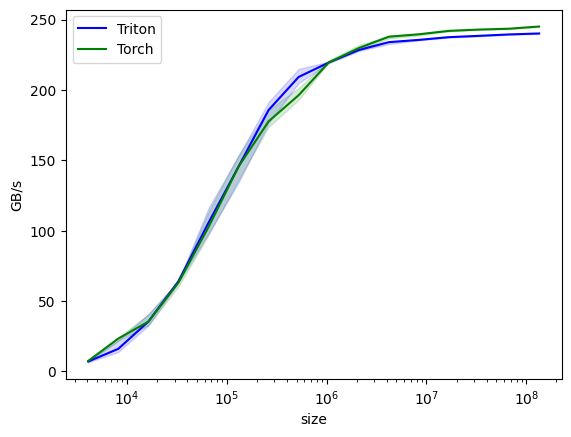

vector-add-performance:
           size      Triton       Torch
0        4096.0    6.981818    7.384615
1        8192.0   15.999999   23.272727
2       16384.0   35.310345   35.310345
3       32768.0   63.999998   63.015384
4       65536.0  105.476395  102.400003
5      131072.0  145.420113  145.420113
6      262144.0  185.654385  177.604328
7      524288.0  209.157447  196.215579
8     1048576.0  219.428568  219.428568
9     2097152.0  228.282153  229.682243
10    4194304.0  233.917907  237.772341
11    8388608.0  235.511559  239.510281
12   16777216.0  237.458234  241.941858
13   33554432.0  238.403038  242.850077
14   67108864.0  239.392948  243.470333
15  134217728.0  240.079781  245.013480


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    y = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: add(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

# Day 2

In [3]:
@triton.jit
def _relu(
    x_ptr,
    output_ptr,
    num_el,
    BLOCK_SIZE: tl.constexpr
):

  pid = tl.program_id(axis=0)

  block_start = pid * BLOCK_SIZE

  offs = block_start + tl.arange(0, BLOCK_SIZE)

  mask = offs < num_el

  x = tl.load(x_ptr + offs, mask=mask)

  output = tl.maximum(x, 0.0)

  tl.store(output_ptr + offs, output, mask=mask)

In [4]:
def relu(x: torch.Tensor):
  output = torch.empty_like(x)

  assert x.device == torch.device("cuda:0") and output.device == torch.device("cuda:0"), f"Tensors have wrong device expected cuda, but got x: {x.device} and output: {output.device}"

  num_el = output.numel()

  grid = lambda meta: (triton.cdiv(num_el, meta["BLOCK_SIZE"]),)

  _relu[grid](
      x_ptr      = x,
      output_ptr = output,
      num_el     = num_el,
      BLOCK_SIZE = 1024
  )

  return output

In [5]:
torch.manual_seed(0)
size = 100_000
x = torch.rand(size, device="cuda")
output_torch = torch.relu(x)
output_triton = relu(x)
print(output_torch)
print(output_triton)
print(f'The maximum difference between torch and triton is '
      f'{torch.max(torch.abs(output_torch - output_triton))}')

tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0')
tensor([0.3990, 0.5167, 0.0249,  ..., 0.2813, 0.8104, 0.6009], device='cuda:0')
The maximum difference between torch and triton is 0.0


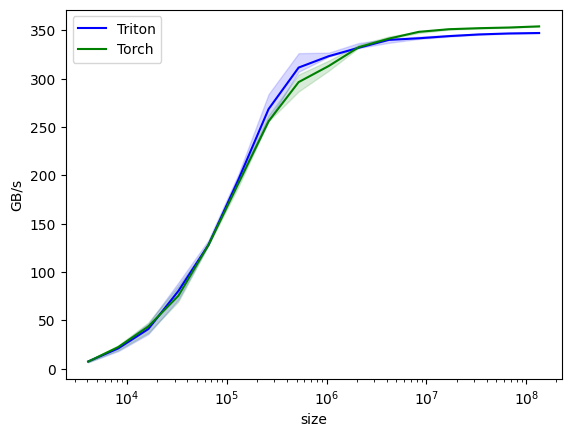

relu-performance:
           size      Triton       Torch
0        4096.0    7.349282    7.245283
1        8192.0   20.897959   22.260869
2       16384.0   40.959998   43.574469
3       32768.0   80.313725   75.386501
4       65536.0  127.999995  127.999995
5      131072.0  195.824709  192.000000
6      262144.0  268.590169  255.999991
7      524288.0  311.581630  296.542993
8     1048576.0  323.368435  313.194740
9     2097152.0  332.108094  332.670041
10    4194304.0  340.225824  341.518617
11    8388608.0  341.908362  348.595753
12   16777216.0  344.133903  351.281743
13   33554432.0  345.879179  352.344086
14   67108864.0  346.899500  353.045990
15  134217728.0  347.363956  354.231202


In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='relu-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.relu(x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: relu(x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)